In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os

os.chdir("../../")
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "b"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

36


In [5]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
locpath = os.path.join("results", results_subfolder, "random forest")
Path(locpath).mkdir(parents=True, exist_ok=True)

In [7]:
# Make sure we're not over fitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=settings_dict["seed_choice"]
)

rfc = RandomForestClassifier(
    random_state=settings_dict["seed_choice"], max_depth=3, n_jobs=-1
)
# Important to make sure it's not overfitting.
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.7710843373493976
0.7073170731707317


In [8]:
y_pred = cross_val_predict(rfc, X, y, cv=5, n_jobs=-1)

F1 = 69.78 %
Accuracy = 69.98 %
Matthew's Coefficient = 40.51 %


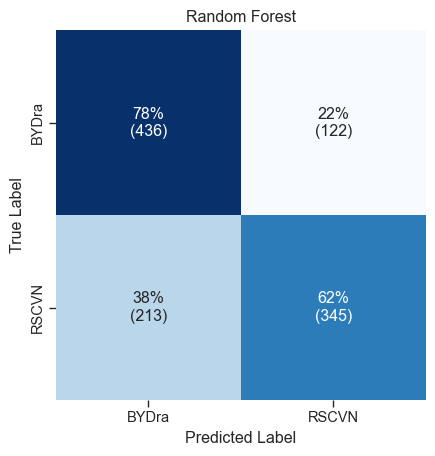

In [9]:
acc = accuracy_score(y, y_pred)
f1score = f1_score(y, y_pred, average="macro")
matthew_coef = matthews_corrcoef(y, y_pred)
print(
    f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
)

ax = utils.plot_cm(y_true=y, y_pred=y_pred)

plt.title("Random Forest")
plt.savefig(os.path.join(locpath, "confusion_matrix.pdf"), bbox_inches="tight")
plt.show()

In [10]:
from IPython.display import display, HTML

filepath1 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "Clark",
    "sfs_best_confusion_matrix.pdf",
)
filepath2 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "Canberra",
    "sfs_best_confusion_matrix.pdf",
)

html_str = f"""
<div style='width: 100%; display: flex;'>
    <iframe src='../../{filepath1}' width='50%' height='500'></iframe>
    <iframe src='../../{filepath2}' width='50%' height='500'></iframe>
</div>
"""

# Display the PDFs side by side
display(HTML(html_str))

In [11]:
dat = np.hstack([y_pred.reshape(-1, 1), y.reshape(-1, 1)])
objs = X_df.index
preds_best_df = pd.DataFrame(data=dat, columns=["y_pred", "y_true"], index=objs)
preds_best_df.to_csv(os.path.join(locpath, "preds_best.csv"))

In [12]:
rfc.fit(X, y)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.DataFrame(
    data=np.concatenate([importances.reshape(-1, 1), std.reshape(-1, 1)], axis=1),
    index=X_df_FULL.columns,
    columns=["importance", "std"],
)

In [13]:
forest_importances["sum"] = forest_importances["importance"] + forest_importances["std"]
forest_importances = forest_importances.sort_values(by="sum", ascending=False)

In [14]:
feats_top_plot = 15

tempdf = forest_importances.iloc[:feats_top_plot]
tempdf.index.name = "feature"

y = tempdf["importance"]
yerr = tempdf["std"]
x = tempdf.index

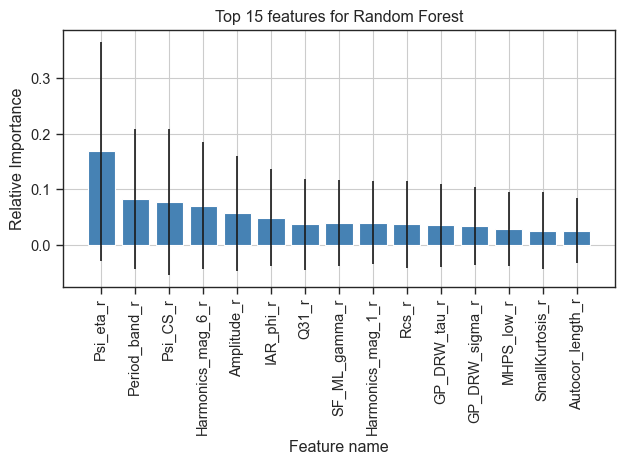

In [15]:
fig, ax = plt.subplots()

ax.bar(x, y, yerr=yerr, color="SteelBlue")
plt.xticks(rotation=90)
plt.title(f"Top {feats_top_plot} features for Random Forest")
plt.xlabel("Feature name")
plt.ylabel("Relative Importance")
plt.tight_layout()
plt.savefig(os.path.join(locpath, "feature_importance.pdf"), bbox_inches="tight")
plt.show()

See final result comparison here:
- https://docs.google.com/spreadsheets/d/1cNaXAjW_RMu3y6MUPkNmjOs03kbRjExU9YLIAjg8A-M/edit?usp=sharing